# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель**

Определить регион, где бурить новую нефтяную скважину.

**Задача**

Построить модель для определения региона, где добыча принесёт наибольшую прибыль

**Описание данных**

В данном проекте 3 датасета: `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv` со следующими признакми

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

**План проекта**
1.  [Загрузка и подготовка данных](#1)
    1. [Вывод](#11) 
2. [Обучение и проверка модели](#2)
    1. [Вывод](#21)
3. [Подготовка к расчёту прибыли](#3)
    1. [Вывод](#31)
4. [Расчёт прибыли и рисков](#4) 
5. [Общий вывод по проекту](#5)

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# для статистического анализа
from scipy import stats as st
from scipy.stats import jarque_bera, ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#для обучения модели
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
plt.rcParams['figure.figsize'] = 16,5
sns.set_style("darkgrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format) # отображение чисел с 2 знаками после запятой

In [3]:
# Ключевые значения для расчётов
exploration_points = 500  # Количество точек при разведке региона
development_points = 200  # Количество лучших точек для разработки
budget = 10e9  # Бюджет на разработку скважин в регионе (10 млрд рублей)
barrel_price = 450  # Цена одной баррели сырья (450 рублей)
income_per_unit = 450000  # Доход с каждой единицы продукта (450 тыс. рублей)

## Загрузка и подготовка данных <a id='1'></a>

Заугрзим датасеты `geo_data_0.csv`, `geo_data_1.csv` и `geo_data_2.csv` и передадим их в перемнные `geo_data_0`, `geo_data_1` и `geo_data_2`. Также убедимся, что данные находятся в нужно директории.

In [4]:
    pth1 = 'datasets/geo_data_0.csv'
    pth2 = 'datasets/geo_data_1.csv'
    pth3 = 'datasets/geo_data_2.csv'
    
    
    if (os.path.exists(pth1)) and (os.path.exists(pth2)) and (os.path.exists(pth3)):
        geo_data_0 = pd.read_csv(pth1)
        geo_data_1 = pd.read_csv(pth2)
        geo_data_2 = pd.read_csv(pth3)
    else:
        print('Error Data path')

In [5]:
class info_data:
    
    def __init__(self, data):
        self.data = data
        
    def data_info(self):
        display(self.data.info())
        
    def data_describe(self):
        display(self.data.describe())
        
    def data_head(self, n=10):
        display(self.data.head(n))

In [6]:
info_data(geo_data_0).data_info()
info_data(geo_data_0).data_describe()
info_data(geo_data_0).data_head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04
5,wX4Hy,0.97,0.49,-0.74,64.74
6,tL6pL,0.65,0.53,1.78,49.06
7,BYPU6,-0.40,0.81,-5.62,72.94
8,j9Oui,0.64,-0.55,2.37,113.36
9,OLuZU,2.17,0.56,9.44,127.91


In [7]:
info_data(geo_data_1).data_info()
info_data(geo_data_1).data_describe()
info_data(geo_data_1).data_head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77
5,HHckp,-3.33,-2.21,3.00,84.04
6,h5Ujo,-11.14,-10.13,4.00,110.99
7,muH9x,4.23,-0.00,2.00,53.91
8,YiRkx,13.36,-0.33,5.00,134.77
9,jG6Gi,1.07,-11.03,5.00,137.95


In [8]:
info_data(geo_data_2).data_info()
info_data(geo_data_2).data_describe()
info_data(geo_data_2).data_head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60
5,LzZXx,-0.76,0.71,2.59,90.22
6,WBHRv,-0.57,0.32,1.77,45.64
7,XO8fn,-1.91,-2.46,-0.18,72.48
8,ybmQ5,1.78,-0.28,3.00,106.62
9,OilcN,-1.21,-0.44,5.92,52.95


Итак, все датасеты имеют одинковое количество записей, названия столбцов совпадают, пропуски в данных отсутствуют, тип данных соответствуют. Далее стоит изучить датасеты на наличие дубликатов и выявить общего числа. <a id='11'></a> <a id='2'></a>

In [9]:
def dup_data():
    
    df = {
        'Регион 1': geo_data_0,
        'Регион 2': geo_data_1,
        'Регион 3': geo_data_2
         }
    
    for n, _ in df.items():
        print(f'Дубликаты в {n}:', _.duplicated().sum())
        print(f'В процентом соотношение от общега числа:', round((_.duplicated().sum() / len(_)), 2) * 100, f'%')

In [10]:
dup_data()

Дубликаты в Регион 1: 0
В процентом соотношение от общега числа: 0.0 %
Дубликаты в Регион 2: 0
В процентом соотношение от общега числа: 0.0 %
Дубликаты в Регион 3: 0
В процентом соотношение от общега числа: 0.0 %


Дубликаты в датасетах отсутсвуют. Так для дальнейшего исследования не пригодится столбец `id`, уберем его.

In [11]:
geo_data_0.drop(['id'], axis = 1, inplace=True)
geo_data_1.drop(['id'], axis = 1, inplace=True)
geo_data_2.drop(['id'], axis = 1, inplace=True)

Теперь требуется провести исследовательский анализ полученных данных. Для одномерного анализа данных подойдут гистограммы с  "боксплотами", для двумерного возьмем матрицу корреляции и посмотрим на графики рассеивания. Ниже представленн класс, в котором хранятся все функции для исследователького шага.

In [12]:
class data_graphic:
    
    def __init__(self, datasets):
        self.datasets = datasets
        
    def hist_boxplot(self):
        # Создание subplots для каждого датасета (3 строки, 4 столбца)
        fig, axs = plt.subplots(6, 4, figsize=(15, 10), gridspec_kw={'height_ratios': [0.5, 1.5, 0.5, 1.5, 0.5, 1.5]})

        for i, dataset in enumerate(self.datasets):
            for j in range(4):  # 4 признака
                # Создание boxplot
                axs[i*2, j].boxplot(dataset.iloc[:, j], vert=False)
                axs[i*2, j].set_yticks([])  # Удаление делений на оси y
                axs[i*2, j].set_xticks([]) # Удаление делений на оси x
        
                # Создание гистограммы
                sns.histplot(dataset.iloc[:, j], ax=axs[i*2+1, j], bins=15, kde=False, stat='density', common_norm=False)
        
                # Вычисление среднего
                mean_value = dataset.iloc[:, j].mean()
        
                # Добавление значения среднего в легенду
                axs[i*2+1, j].legend([f'Mean: {mean_value:.2f}'], loc='upper right')
        
                axs[i*2+1, j].set_yticks([])  # Удаление делений на оси y
                axs[i*2+1, j].set_ylabel('')  # Удаление названия оси y
        
        # Установка названий строк (датасетов)
        for ax, row in zip(axs[:, 0], ['Регион 1', 'Плотность', 'Регион 2', 'Плотность', 'Регион 3', 'Плотность']):
            ax.set_ylabel(row)

        fig.suptitle('Распределения признаков датасетов', fontsize=20)
        plt.tight_layout()
        plt.show()
        
    def heatmap_data(self):
        
        # Создадим сетку графиков с помощью subplots
        fig, axes = plt.subplots(ncols=len(self.datasets), figsize=(15, 6))

        # Пройдемся по всем датасетам и построим тепловую карту корреляции
        for i, dataset in enumerate(self.datasets):
            sns.heatmap(dataset.corr(), cmap='coolwarm', annot=True, ax=axes[i])
            axes[i].set_title(f'geo_data_{i} - Correlation Heatmap')

        fig.suptitle('Тепловые карты датасетов', fontsize=20)
        plt.tight_layout()
        plt.show()
        
    def pair_plot(self):
        
        sns.pairplot(self.datasets)
        
        plt.suptitle(f'График рассеяния', fontsize=20)
        plt.show()

Также неплохо было бы провести статестические тесты для датасетов. Это нужно, в целом чтобы понять, нормальные ли они, статистически ли значимы между группами. Ниже представлен класс, который хранит функции с статистическими тестами. Тесты, которые будут использоватся в проекте: `Шапиро-Уилка`, `ANOVA`. Также ниже уже конкретно для каждого теста будут представлены гипотезы.

In [13]:
class data_stat:
    
    def __init__(self, datasets):
        self.datasets = datasets
        
    def norm_data(self):
        # Создание DataFrame для хранения результатов теста
        results = pd.DataFrame(columns=['Dataset', 'Feature', 'JB-statistic', 'p-value'])

        # Применение теста Шапиро-Уилка к каждому датасету и признаку
        for i, dataset in enumerate(self.datasets):
            for j in range(4):  # 4 признака
                stat, p = jarque_bera(dataset.iloc[:, j])
                results = results.append({'Dataset': f"geo_data_{i}", 
                                          'Feature': f"f{j}" if j < 3 else "product", 
                                          'JB-statistic': stat, 'p-value': p}, 
                                          ignore_index=True)

        # Вывод результатов в виде таблицы
        display(results)
        
    def anova_data(self):
        # Создадим список для хранения результатов
        results = pd.DataFrame(columns=['Feature', 'F-statistic', 'p-value'])

        # Выполним тест ANOVA для каждого признака
        for feature in ['f0', 'f1', 'f2', 'product']:
            data = [dataset[feature] for dataset in self.datasets]
            f_statistic, p_value = f_oneway(*data)
            results = results.append({'Feature': feature, 'F-statistic': f_statistic, 'p-value': p_value}, ignore_index=True)

        # Выведем результаты в виде таблицы
        display(results)

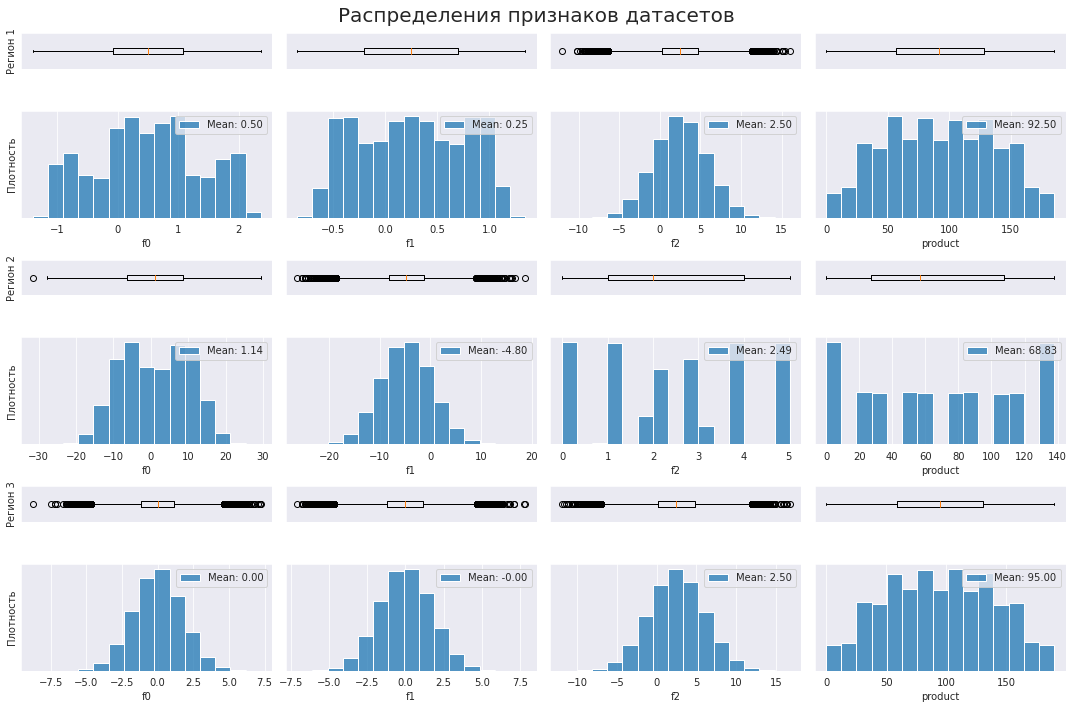

In [14]:
data_graphic([geo_data_0, geo_data_1, geo_data_2]).hist_boxplot()

Гипотеза для проверки на нормальность:

- H0: Признаки (f0, f1, f2, product) из региона 1 (2,3) распределены нормально.
- H1: Признаки (f0, f1, f2, product) из региона 1 (2,3) не распределены нормально.

In [15]:
data_stat([geo_data_0, geo_data_1, geo_data_2]).norm_data()

,Dataset,Feature,JB-statistic,p-value
0,geo_data_0,f0,3145.97,0.00
1,geo_data_0,f1,5861.51,0.00
2,geo_data_0,f2,51.80,0.00
3,geo_data_0,product,3772.83,0.00
4,geo_data_1,f0,3737.85,0.00
5,geo_data_1,f1,6.82,0.03
6,geo_data_1,f2,6634.56,0.00
7,geo_data_1,product,6609.14,0.00
8,geo_data_2,f0,1.23,0.54
9,geo_data_2,f1,4.29,0.12


Проверка значимости различий признаков f0, f1, f2 и объемом запасов в скважинах (product) между 3 регионами.

- H0: Среднее значение признака f0 (f1, f2, product) во всех 3-х регионах одинаковы.
- H1: По крайней мере в одном регионе средние значения признака f0 (f1, f2, product) отличаются.

In [16]:
data_stat([geo_data_0, geo_data_1, geo_data_2]).anova_data()

,Feature,F-statistic,p-value
0,f0,1162.87,0.00
1,f1,82344.09,0.00
2,f2,0.24,0.79
3,product,10303.70,0.00


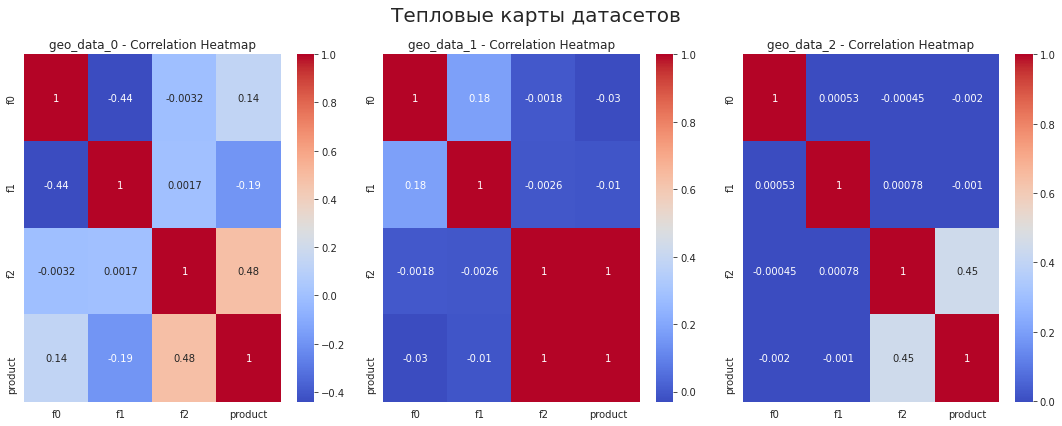

In [17]:
data_graphic([geo_data_0, geo_data_1, geo_data_2]).heatmap_data()

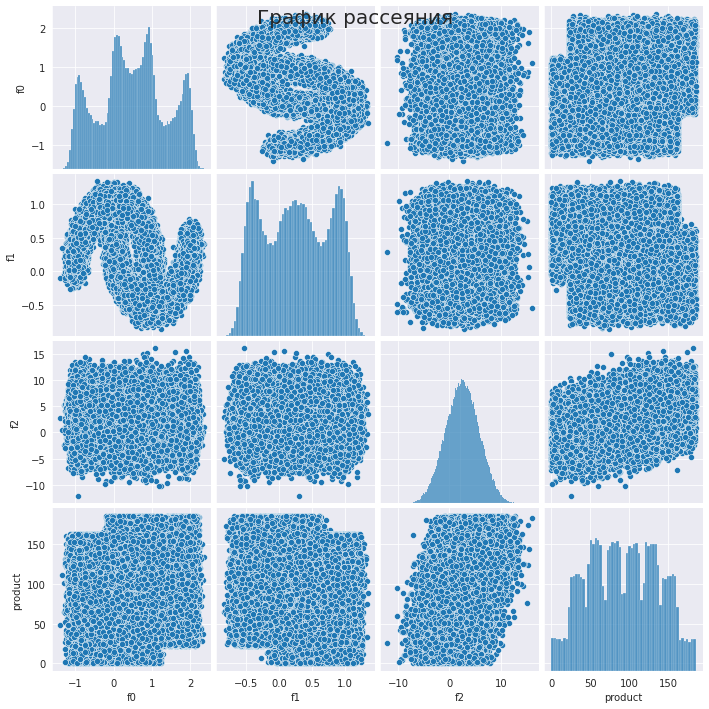

In [18]:
data_graphic(geo_data_0).pair_plot()

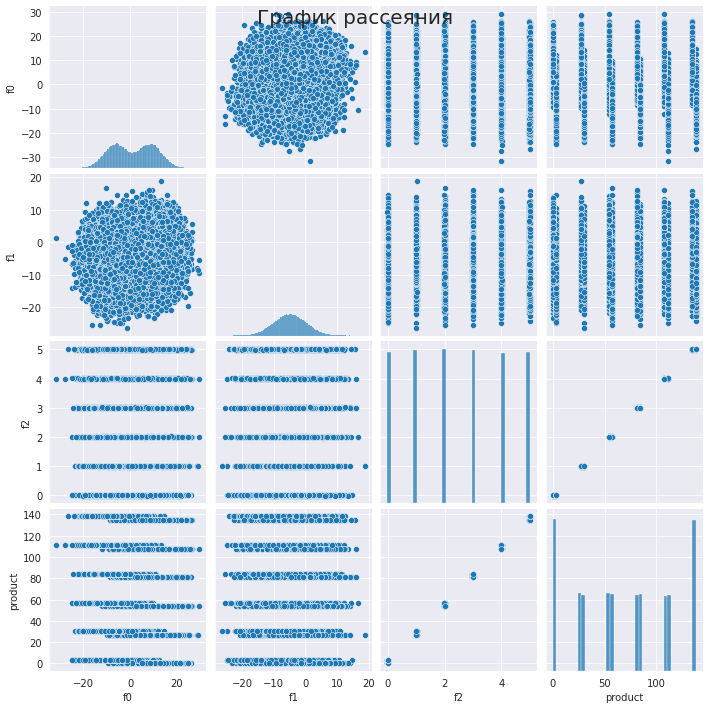

In [19]:
data_graphic(geo_data_1).pair_plot()

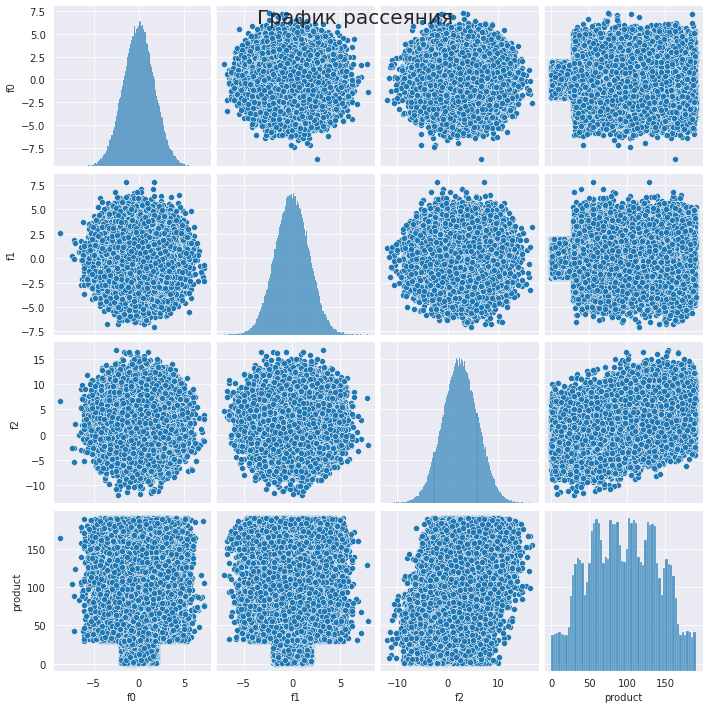

In [20]:
data_graphic(geo_data_2).pair_plot()

### Вывод по входным данным <a id='21'></a>

**Регион 1**

Все признаки в этот датасете не распределены нормально, т.к. p-value ≤ 0.05 во всех случаях, следовательно, мы отклоняем гипотезу о нормальности распределений. В целом, даже заметно по гистограмма, в `f0` и `f1` - присутствует мультимодальность. Также стоит заметить наличие выбросов в `f2`, ниже, как и для других принаков в регионах 2 и 3, уберем их. Что касется корреляции, присутствет незначительная связь между `f2` и `product`, и по графику рассеяния видно, что они линейно зависимы, в отличие от других. 

**Регион 2**

Аналогична и ситация для 2 региона - данные также не распределены нормально (p-value ≤ 0.05), отклоняем гипотезу H0 и принимаем альтернативную. В `f1` присутствуют выбросы. Видим, что присутствует сильную линейную связь между `f2` и `product`.  В таком случае, признак `f2` может быть значимым предиктором для объема запасов `product` в регионе 2.

**Регион 3**

Для признаков `f0` и `f1` принимаем гипотезу H0 - они распределены нормально, для других отклоняем, так как p-value ≤ 0.05. При этом в признаках `f0`, `f1`, `f2` присутствуют выбросы. Как и в 1 регионе, присутствует линейная связь между `f2` и `product`. 

Да и в целом, тест ANOVA показал, что признак `f2` оказывает оказывают влияние на объем запасов в скважине.

## Обучение и проверка модели

На данном этапе требуется обучить модель при помощи линейной регрессии. Для этого разделим данные на обучающую и валидационную выборки в соотношении 75:25. Далее обучим модель и сделаем предсказания на валидационной выборке. После выведем предсказания и правильные ответы на валидационной выборке, и метрики RMSE и R2.

In [21]:
class data_model:
    
    def __init__(self, datasets):
        self.datasets = datasets
        self.models = {}  # Словарь для хранения моделей
        self.real_means = {}  # Словарь для хранения реальных средних запасов для каждого региона
        self.predictions = {}  # Словарь для хранения прогнозов для каждого региона
        self.target_valid = {}  # Словарь для хранения целевых значений для каждого региона
        
    def split_data(self):
        # разделяем данные на тренировочные, тестовые и валидационные
        for i, dataset in enumerate(self.datasets):
            variable_name = f'geo_data_{i}'  # Создаем имя переменной
            setattr(self, variable_name, dataset)  # Устанавливаем атрибут объекта с этим именем
            print(variable_name)

            target = dataset['product']
            features = dataset.drop('product', axis=1)
            
            features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                          target, 
                                                                                          random_state=12345, 
                                                                                          test_size=0.25)
            
            # Устанавливаем атрибуты объекта с тренировочными и валидационными данными
            setattr(self, f'{variable_name}_train_features', features_train)
            setattr(self, f'{variable_name}_valid_features', features_valid)
            setattr(self, f'{variable_name}_train_target', target_train)
            setattr(self, f'{variable_name}_valid_target', target_valid)
            
            print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)
            
    def rem(self, data, col):
        # Убираем выбросы используя межквартильный размах
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = (Q3 - Q1) * 1.5
        return data[(data[col] > Q1 - IQR) & (data[col] < Q3 + IQR)]
    
    def rem_geo(self):
        # Для региона 1 убираем выбросы в f2
        # Для региона 2 убираем выбросы в f1
        # Для региона 3 убираем выбросы в f0, f1, f2
        
        for i, dataset in enumerate(self.datasets):
            variable_name = f'geo_data_{i}'
            features_train = getattr(self, f'{variable_name}_train_features')
            target_train = getattr(self, f'{variable_name}_train_target')
            
            initial_row_count = features_train.shape[0]
            
            if variable_name == 'geo_data_0':
                columns_to_check = ['f2']
            elif variable_name == 'geo_data_1':
                columns_to_check = ['f1']
            elif variable_name == 'geo_data_2':
                columns_to_check = ['f0', 'f1', 'f2']
            else:
                columns_to_check = []
           
            if columns_to_check:
                indexes_removing = [set(self.rem(features_train, col).index) for col in columns_to_check]
                common_indexes = indexes_removing[0]
                for indexes in indexes_removing[1:]:
                    common_indexes &= indexes
                common_indexes = list(common_indexes)
                features_train = features_train.loc[common_indexes]
                target_train = target_train.loc[common_indexes]
                
            # Обновляем тренировочные данные после удаления выбросов
            setattr(self, f'{variable_name}_train_features', features_train)
            setattr(self, f'{variable_name}_train_target', target_train)
            
            final_row_count = features_train.shape[0]
            removed_percentage = (initial_row_count - final_row_count) / initial_row_count * 100
            
            print(f'Размер датасета после удаления выбросов {variable_name}:')
            print(features_train.shape, target_train.shape)
            print(f'Удалено {removed_percentage:.2f}% строк')
            
    def train_model(self):
        # Создаем и обучаем модели для каждого региона
        for i in range(len(self.datasets)):
            variable_name = f'geo_data_{i}'
            features_train = getattr(self, f'{variable_name}_train_features')
            target_train = getattr(self, f'{variable_name}_train_target')
            features_valid = getattr(self, f'{variable_name}_valid_features')
            target_valid = getattr(self, f'{variable_name}_valid_target')
            
            # Создаем и обучаем модель с помощью Pipeline
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('linear_regression', LinearRegression())
            ])
            model = pipe.fit(features_train, target_train)
            self.models[variable_name] = model
            
            # Предсказываем целевые значения на валидационных данных и выводим результаты
            predictions = model.predict(features_valid)
            
            # Сохраняем предсказания и правильные значения для каждого региона
            self.predictions[variable_name] = predictions
            self.target_valid[variable_name] = target_valid
            
            # Вычисляем метрики
            mse = mean_squared_error(target_valid, predictions)**.5
            r2 = r2_score(target_valid, predictions)
            real_mean = target_valid.mean()  # Сохраняем реальный средний запас
            self.real_means[variable_name] = real_mean
            print(f'Для {variable_name}')
            print(f'Реальный средний запас {real_mean}')
            print(f'Средний объем предсказанного сырья {predictions.mean()}')
            print(f'RMSE = {mse}')
            print(f'R^2 = {r2}')

Созданим экземпляра класса `data_model` с тремя датасетами `geo_data_0`, `geo_data_1`, `geo_data_2`.

In [22]:
model = data_model([geo_data_0, geo_data_1, geo_data_2])

Разделем данные на тренировочные и валидационные и выведем их размер.

In [23]:
model.split_data()

geo_data_0
(75000, 3) (25000, 3) (75000,) (25000,)
geo_data_1
(75000, 3) (25000, 3) (75000,) (25000,)
geo_data_2
(75000, 3) (25000, 3) (75000,) (25000,)


Теперь удалим строки с выбросами. Помним, что удалить можно не более 10%

In [24]:
model.rem_geo()

Размер датасета после удаления выбросов geo_data_0:
(74623, 3) (74623,)
Удалено 0.50% строк
Размер датасета после удаления выбросов geo_data_1:
(74520, 3) (74520,)
Удалено 0.64% строк
Размер датасета после удаления выбросов geo_data_2:
(73468, 3) (73468,)
Удалено 2.04% строк


И наконец обучим модель и получим метрики для каждого исследуемого региона.

In [25]:
model.train_model()

Для geo_data_0
Реальный средний запас 92.07859674082927
Средний объем предсказанного сырья 92.58060938810507
RMSE = 37.579599693620175
R^2 = 0.27993639475898
Для geo_data_1
Реальный средний запас 68.72313602435997
Средний объем предсказанного сырья 68.72881074193896
RMSE = 0.8931124419988995
R^2 = 0.9996233867858415
Для geo_data_2
Реальный средний запас 94.88423280885438
Средний объем предсказанного сырья 94.75764220268914
RMSE = 40.026964151753006
R^2 = 0.2053565623471949


### Вывод <a id='31'></a>

Из анализа результатов следует, что модель имеет высокую точность предсказания для региона `geo_data_1`, демонстрируя почти идеальное соответствие фактическим данным. Это обусловлено сильной линейной зависимостью, которая была выявлена при построении корреляционной матрицы параметра f2. Однако для других регионов (`geo_data_0` и `geo_data_2`) модель показывает более скромные результаты с более высокими значениями среднеквадратичной ошибки и низким коэффициентом детерминации.

## Подготовка к расчёту прибыли <a id='3'></a>

Переданы следующие входные условия:

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Цена одной баррели сырья приносит 450 рублей дохода.
- Доход с каждой единицы продукта составляет 450 тыс. рублей.

Требуется достаточный объем сырья для безубыточности разработки новой скважины (т.е. найти точку безубыточности) и сравнить ее со средним запасом в каждом регионе.

С точки зрения экономики, точкой безубыточности является момент, когда расходы равны доходам. С геометрической точки зрения, это точка пересечения функций дохода и расхода.

Имеем следующую формулу: Затраты=Выручка. Затраты в нашем случае вычисляются, как соотношения бюджета к количеству скважен отобранных с помощью машинного обучения. Выручка представляет произведение дохода с каждой единицы продукта на объем сырья.

Получается следующая формула:

Объем сырья = Бюджет / Количеству скважен отобранных с помощью МО / Доход с каждой единицы продукта

In [26]:
class ProfitCalculator:

    def __init__(self, real_means, budget, development_points, income_per_unit, exploration_points, predictions, target_valid):
        self.real_means = real_means
        self.budget = budget
        self.development_points = development_points
        self.income_per_unit = income_per_unit
        self.exploration_points = exploration_points
        self.predictions = predictions
        self.target_valid = target_valid

        # Сброс индексов
        self.target_valid = {region: df.reset_index(drop=True) for region, df in self.target_valid.items()}
        self.predictions = {region: pd.Series(pred).reset_index(drop=True) if not isinstance(pred, pd.Series) else pred for region, pred in self.predictions.items()}

    def calculate_mean_cvp(self):
        cvp = self.budget / self.development_points / self.income_per_unit
        mean_cvp_values = {region: round(mean - cvp, 2) for region, mean in self.real_means.items()}
        return cvp, mean_cvp_values

    def profit_region(self, target_valid, predictions):
        region_profits = {}
        for region, pred in predictions.items():
            pred_series = pd.Series(pred)
            pred_sort = pred_series.sort_values(ascending=False)[:self.development_points]
            select_indx = target_valid[region].iloc[pred_sort.index]
            profit = self.income_per_unit * select_indx.sum() - self.budget
            region_profits[region] = profit
        return region_profits

    def payback_period(self, region):
        month_profit = self.profit_region(self.target_valid, self.predictions)[region] / 12
        payback_period_month = self.budget / month_profit if month_profit != 0 else float('inf')
        return payback_period_month 
    
    def bootstrap(self, predictions, target_valid):
        results = {}
        state = np.random.RandomState(12345)
        
        for region in predictions.keys():
            values = []
            for _ in range(1000):
                target_sample = target_valid[region].reset_index(drop=True).sample(
                    n=self.exploration_points, replace=True, random_state=state)
                pred_sample = predictions[region][target_sample.index]
                
                profit = self.profit_region({region: target_sample}, {region: pred_sample})[region]
                values.append(profit)
             
            values = pd.Series(values)
            lower = round(values.quantile(0.025), 2)
            upper = round(values.quantile(0.975), 2)
            mean_values = round(values.mean(), 2)
            risk = round((values < 0).mean() * 100)
            
            results[region] = (mean_values, lower, upper, risk)
        
        return results

In [27]:
profit_calculator = ProfitCalculator(
    model.real_means, 
    budget, 
    development_points, 
    income_per_unit, 
    exploration_points,  
    model.predictions, 
    model.target_valid)
cvp, mean_cvp_values = profit_calculator.calculate_mean_cvp()
print(f'Достаточный объем сырья для безубыточности разработки новой скважины {round(cvp, 2)}')
print('Разница между средним запасом и достаточным объемом для безубыточности:')
print(mean_cvp_values)

for region, mean_value in model.real_means.items():
    if mean_value >= cvp:
        print(f'Средний запас в регионе {region} достаточен для безубыточной разработки.')
    else:
        print(f'Средний запас в регионе {region} недостаточен для безубыточной разработки.')

Достаточный объем сырья для безубыточности разработки новой скважины 111.11
Разница между средним запасом и достаточным объемом для безубыточности:
{'geo_data_0': -19.03, 'geo_data_1': -42.39, 'geo_data_2': -16.23}
Средний запас в регионе geo_data_0 недостаточен для безубыточной разработки.
Средний запас в регионе geo_data_1 недостаточен для безубыточной разработки.
Средний запас в регионе geo_data_2 недостаточен для безубыточной разработки.


### Вывод

Достаточный объем сырья для безубыточности разработки новой скважины составляет 111.11 тыс. бареллей. При этом данный результат гораздо больше средних во всех регионах. Ближе к точки безубыточности находится средний запас в 3 регионе (geo_data_2) (-16.23).

## Расчёт прибыли и рисков <a id='4'></a>

Каждый бизнес направлен на получение прибыли. Чтобы его найти, сделаем его шаги:

1. Выберем скважины с максимальными значениями предсказаний.
2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.

Тем не менее, хочу от себя добавить, бизнес смотрит не только на суммарную прибыль, но и на срок окупаемости той или иной инвестиции. По хорошему, надо вычеслить этот показатель, чтобы у инвестора не было вопроса, когда будут возмещены все инвестиции.

In [28]:
region_profits = profit_calculator.profit_region(model.target_valid, model.predictions)
for region in model.real_means.keys():
    profit = region_profits[region]
    month_payback = profit_calculator.payback_period(region)
    print(f'Прибыль для региона {region}: {profit:.2f}')
    print(f'   Срок окупаемости в месяцах {month_payback:.0f}')

Прибыль для региона geo_data_0: 3320826043.14
   Срок окупаемости в месяцах 36
Прибыль для региона geo_data_1: 2415086696.68
   Срок окупаемости в месяцах 50
Прибыль для региона geo_data_2: 2709139745.23
   Срок окупаемости в месяцах 44


Больше всего принесет прибыль 1 региона (geo_data_0) -  3320826043 со сроком окупаемости в 36 месяцев. 

Также немало важно оценить риски вложений для каждого региона. Ведь вполне очевидно, если риски будут высокие, то возможен исход потери частиили или всей суммы капитала. С помощью техники Bootstrap с 1000 выборками найдем распределения прибыли, средние по каждому региону и процент риска.

In [29]:
bootstrap_results = profit_calculator.bootstrap(model.predictions, model.target_valid)
for region, result in bootstrap_results.items():
    average, lower, upper, risk = result
    print(f'Результаты бутстрап-анализа для региона {region}:')
    print(f'   95% доверительный интервал ({lower},{upper})')
    print(f'   Средняя прибыль: {average}')
    print(f'   Риск убытков: {risk}%')

Результаты бутстрап-анализа для региона geo_data_0:
   95% доверительный интервал (-111215545.89,910583217.49)
   Средняя прибыль: 396771294.43
   Риск убытков: 7%
Результаты бутстрап-анализа для региона geo_data_1:
   95% доверительный интервал (78050810.75,862952060.26)
   Средняя прибыль: 461157247.87
   Риск убытков: 1%
Результаты бутстрап-анализа для региона geo_data_2:
   95% доверительный интервал (-112227625.38,929810636.43)
   Средняя прибыль: 393998618.78
   Риск убытков: 6%


Исходя из полученного результата по рискм, лучше всего вкладываться во 2 регион (geo_data_1). Это обусловлено тем, что он обладает наибольшой средней прибылью (461157247.87) и наименьшим риском убытка (всего 1%). Также нам дано условие, что риски не должны превышать 2.5%

## Общий вывод по проекту <a id='5'></a>

В этом проекте требуется определить, в каком регионе лучше всего бурить новую нефтяную скважину. Были получены датасеты с 3 регионами, которые содержат три признака точек (f0, f1, f2) и объём запасов в скважине (product) (id не берем в расчет, т.к. для иследования он не пригодился и был удален). Далее перечислю ключевые краткие выводы по проекту:

- В ходе исследования данных было установлено, что f2 имеет существенное влияние на объем запасов product во 2 регионе (geo_data_1).
- Была обучена модель с помощью линейной регрессии и выявлены метрики RMSE и R2. Лучше всего показал 2 (geo_data_1) регион с показателями: Средний объем предсказанного сырья 68.73, RMSE = 0.89, R^2 = 0.99962.  Хотб она предсказывает меньший объем сырья, но точность модели гораздо выше.
- Была получена точка безубыточности в размере 111.11. Ближе к точки безубыточности находится средний запас в 3 регионе (geo_data_2) с результатом -16.23.
- Наибольшую прибыльность и минимальный сроку окупаемости было получено в 1 регионе (geo_data_0) - 3320826043 и 36 месяцев.
- Минимальный риск вложения (всего 1%) показал 2 регион (geo_data_1) со значениями средней прибыли в 461157248.

Таким образом, регион 2 (geo_data_1) представляет собой оптимальный выбор с учетом сочетания высокой прибыльности, минимального риска и точности прогнозирования.